# Exchange economy with many heterogenous consumers

This notebook shows how to use random numbers to simulate and solve a full equilibrium model with many heterogeneous agents.

In [1]:
# primer
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import ipywidgets as widgets # For interactive plots/buttons

**Single Consumer**
1. 2 goods, $(x_1,x_2)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with uniformly *heterogenous* coefficients
4. with Price $(p_1,p_2)$

$$
\begin{aligned}
u^j(x_1^j,x_2^j)={x_1^j}^{\alpha_j} {x_2^j}^{1-\alpha_j} \\
\alpha_j \sim \mathcal{U}(\underline{\alpha}, \overline{\alpha}), \text{where} \quad 0 < \underline{\alpha}, \overline{\alpha} <1 \\
\text{s.t.} \quad p_1x_1^j + p_2x_2^j \leq I = p_1 e_1^j + p_2 e_2^j
\end{aligned}
$$

5. Assume Endowments are homogenous $\boldsymbol{e^j}=(e_1^j,e_2^j)=(k,1)$
6. According to the FOCs and budget constraint we have
$$
x_1^{j*} = \alpha_j \frac{I}{p_1} \\
x_2^{j*} = (1-\alpha_j) \frac{I}{p_2}
$$

In [2]:
class ConsumerClass():
    def __init__(self,alpha,k):
        # Cobb-Douglas parameter
        self.alpha = alpha
        # Homogenous endowments
        self.endowments = [k,1]
    
    def demands(self,p1,p2):
        # Demand function derived from FOCs
        Income = p1*self.endowments[0] + p2*self.endowments[1]
        demand_good1 = self.alpha * Income / p1 
        demand_good2 = (1-self.alpha) * Income / p2
        return demand_good1 , demand_good2
    
    def utility(self,p1,p2):
        # maximized utility value
        x1,x2 = self.demands(p1,p2)
        util = x1**self.alpha * x2**(1-self.alpha)
        return util


**Market clearing**

The price vector $(p_1,p_2)$ should satisfy underline equations
$$
 \underset{\text{Demand}} {\underbrace{\sum_{j=1}^N x_1^j}} 
                            =x_1(p1,p2) = \underset{\text{Supply}} {\underbrace{\sum_{j=1}^N e_1^j}} \\
 \underset{\text{Demand}} {\underbrace{\sum_{j=1}^N x_2^j}} 
                            =x_2(p1,p2) = \underset{\text{Supply}} {\underbrace{\sum_{j=1}^N e_2^j}}
$$

**Algorithm:**  `slove_eq()`  
First choose a tolerance $\epsilon > 0$ and an adjustment factor $\kappa>0$, and a guess on $p_{1,0} > 0$. 

Then find the equilibrium price by following iterative algorithm:

1. Calculate total excess demand of good 1: $Z_1 = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - \sum_{j=1}^N e_1^j $ `excess_demand(p1,p2)`
2. If $|Z_1| < \epsilon $ stop
3. If $|Z_1| \geq \epsilon $ set $p_{1,n+1} = p_{1,n} + \kappa \cdot \frac{Z_1}{N}$
4. Return to step 1

**Intuition**  
If excess demand is **positive** and far from 0, then **increase** the price.  
If excess demand is **negative** and far from 0, then **decrease** the price.  

In [8]:
class MarketClass:
    def __init__(self,num_consumers,k):
        np.random.seed(42)
        # homogenous endowment of good 1
        self.k = k
        
        # Define the consumer sets
        self.consumers = [ConsumerClass(alpha=np.random.rand()*0.7+0.2, k=k) for _ in range(num_consumers)]

        # price of good 2 as numerial
        self.p2 = 1
        
        # size of consumer sers
        self.num_consumers = num_consumers

    def total_supply(self):
        total_supply_good1 = sum(consumer.endowments[0] for consumer in self.consumers)
        total_supply_good2 = sum(consumer.endowments[1] for consumer in self.consumers)
        return total_supply_good1 , total_supply_good2
    
    def total_demand(self,p1,p2):
        total_demand_good1 = sum(consumer.demands(p1,p2)[0] for consumer in self.consumers)
        total_demand_good2 = sum(consumer.demands(p1,p2)[1] for consumer in self.consumers)
        return total_demand_good1, total_demand_good2

    def excess_demand(self,p1,p2):
        excess_demand_good1 =  self.total_demand(p1,p2)[0] - self.total_supply()[0]
        excess_demand_good2 =  self.total_demand(p1,p2)[1] - self.total_supply()[1]
        return excess_demand_good1, excess_demand_good2
    
    def solve_eq(self):
        p1_ini = 1       # initial price of good 1
        kappa =0.5       # parameter to solve market condition
        maxiter = 2000   # maximum number of iterations
        iter = 1        # iteration counter
        eps = 1e-8      # convergence tolerance
        diff = 2        # initial excess demand
        
        while iter <= maxiter and diff > eps:
            p1 = p1_ini + kappa * self.excess_demand(p1_ini,self.p2)[0]
            diff = abs(self.excess_demand(p1_ini,self.p2)[0])
            p1_ini = p1
            iter += 1
        # check for convergence:
        if diff > eps:
            print(f'iter: {iter} --> excess demand: {self.excess_demand(p1_ini,self.p2)[0]}')
        return p1,self.p2 
    
    def distribution(self):
        consumptions_good1 = []
        consumptions_good2 = []
        for consumer in self.consumers:
            p1, p2  = self.solve_eq()
            x1 , x2 = consumer.demands(p1,p2)
            consumptions_good1.append(x1)
            consumptions_good2.append(x2)
        return consumptions_good1, consumptions_good2
    
    def social_welfare(self):
        p1,p2 = self.solve_eq()
        wel = sum(consumer.utility(p1,p2) for consumer in self.consumers)
        return wel


In [4]:
# solve the model, get the equilibrium prices

market = MarketClass(num_consumers=20,k=0.5)
equilibrium_prices = market.solve_eq()
print(f'equilibrium prices = {equilibrium_prices}')

welfare = market.social_welfare()
print(f'social welfare = {welfare:.3f}')

equilibrium prices = (2.170068764005229, 1)
social welfare = 15.476


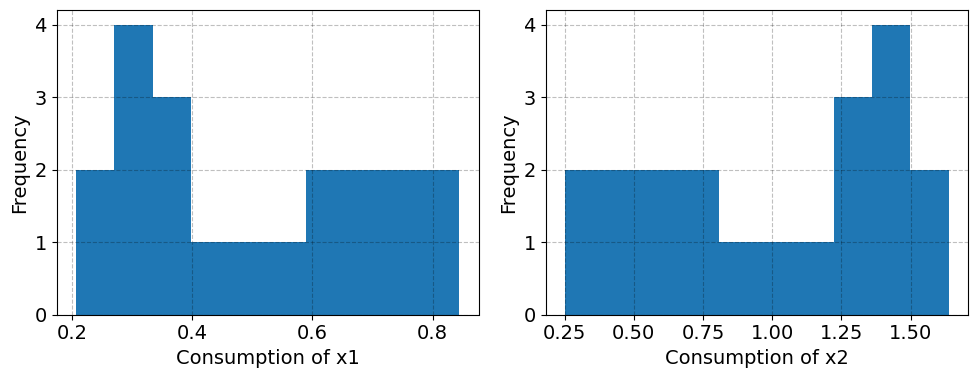

In [5]:
# Plot the distribution of consumptions
consump1,consump2 = market.distribution()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(consump1)
plt.xlabel('Consumption of x1')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(consump2)
plt.xlabel('Consumption of x2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Comparative analysis  
What happend if we change the endowment of consumers $k$ ?  

Create a function constructing a figure

In [9]:
def interactive_figure(num_consumers,k):
    
    # a. calculations
    consump_a,comump_b = MarketClass(num_consumers,k).distribution()
    
    # b. figure
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(consump_a)
    ax.set_xlim([0,1.5]) # fixed x range
    ax.set_ylim([0,8]) # fixed y range
    ax.set_title("Distribution of demand for good 1")
    ax.set_ylabel("Frequency")

Make it interactive with a **slider**

In [10]:
# Write out which arguments to interactive_figure you want to be changing or staying fixed 
widgets.interact(interactive_figure,
    num_consumers=widgets.IntSlider(description=r"N",min=1, max=20, step=1, value=10),
    k=widgets.FloatSlider(description=r"k", min=0.01, max=0.7, step=0.05, value=2)
);


interactive(children=(IntSlider(value=10, description='N', max=20, min=1), FloatSlider(value=0.7, description=…